# Notebook for rereferencing, example with bipolar, CAR and iterable rereference (user defined number of channels).

In this notebook we will explore different re-referencing methods and observe how they impact the estimated features. Only STN-LFP data is going to be used, and we will visualize the features for the cases with:

- no re-referencing
- bipolar re-referecing: we subtract from a given the channel the averaged signal of the channel below it, in default mode it's done for LFP channels. Eg. LFP channel 2 is the reference for LFP channel 1
- CAR -> common averaging re-referencing: we subtract from all channels their common average.

We will also show how the user can set up the list of channels in which respect the re-reference is performed.

In [2]:
import os
import sys
import py_neuromodulation as nm
import xgboost
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
    nm_stats
)
from sklearn import metrics, model_selection
import json
import matplotlib.pyplot as plt
import numpy as np
import re

# change root directory of the project
SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
if SCRIPT_DIR.split("/")[-1] == "py_neuromodulation":
    # this check is necessary, so we can also run the script from the root directory
    SCRIPT_DIR = os.path.join(SCRIPT_DIR, "examples")

sys.path.append(os.path.dirname(SCRIPT_DIR))

# Reload imports to get changes in other scripts
%load_ext autoreload
%autoreload 2

We will use the same data available here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/IO2FLM, but this time with the full recording.

To be able to run this notebook, please download the data of subject-000 and replace `PATH_BIDS` with the path to your downloaded data. Remember to make sure the downloaded data is in the BIDS format. For another format, please look at `example_SimulatedData.ipynb`.

# Sub-000 doesnt have LFP!

In [4]:
sub = "000"
ses = "right"
task = "force"
run = 0
datatype = "ieeg"

# Define run name and access paths in the BIDS format.
RUN_NAME = f"sub-{sub}_ses-{ses}_task-{task}_run-{run}"

PATH_RUN = os.path.join(
    (os.path.join(SCRIPT_DIR, "data")),
    f"sub-{sub}",
    f"ses-{ses}",
    datatype,
    RUN_NAME,
)
PATH_BIDS = "/home/lauraflyra/Documents/BCCN/Pittsburgh_dataset_ECoG_LFP"

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype, #line_noise=60
)


Extracting parameters from /home/lauraflyra/Documents/BCCN/Pittsburgh_dataset_ECoG_LFP/sub-000/ses-right/ieeg/sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/lauraflyra/Documents/BCCN/Pittsburgh_dataset_ECoG_LFP/sub-000/ses-right/ieeg/sub-000_ses-right_task-force_run-0_channels.tsv.
Reading electrode coords from /home/lauraflyra/Documents/BCCN/Pittsburgh_dataset_ECoG_LFP/sub-000/ses-right/ieeg/sub-000_ses-right_task-force_run-0_space-mni_electrodes.tsv.


# Without LFP there's no difference between default and CAR

### Default
Reference must be either 'default', 'None' or an iterable with the desired re-referencing for each channel. This iterable needs to be the same length as `ch_names`. We start with default, which is what was done in all other examples:

In [5]:
# Provide a path for the output data. Each re-referencing method has their PATH_OUT
PATH_OUT = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "default")
nm_channels_default = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference='default',
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog",),
    target_keywords=("MOV_LEFT_CLEAN",),
)

stream_default = nm.Stream(
    settings=None,
    nm_channels=nm_channels_default,
    path_grids=None,
    verbose=False,
)

stream_default.set_settings_fast_compute()

stream_default.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream_default.run(
    data=data,
    out_path_root=PATH_OUT,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-000_ses-right_task-force_run-0/sub-000_ses-right_task-force_run-0_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-000_ses-right_task-force_run-0/sub-000_ses-right_task-force_run-0_FEATURE

### Use common averaging re-reference
As we want to re-reference all LFP channels, but no re-referencing for the rest, we do:

In [8]:
PATH_OUT_avg = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "avg")
ch_names = raw.ch_names
ref = ["average" if "LFP" in item else "None" for item in ch_names]

We need to define the `nm_channels` again and then `stream.run`.

In [9]:
nm_channels_avg = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference=ref,
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog",),  # We focus only on LFP data
    target_keywords=("MOV_LEFT_CLEAN",),
)
stream_avg = nm.Stream(
    settings=None,
    nm_channels=nm_channels_avg,
    path_grids=None,
    verbose=False,
)

stream_avg.set_settings_fast_compute()

stream_avg.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream_avg.run(
    data=data,
    out_path_root=PATH_OUT_avg,
    folder_name=RUN_NAME,
);

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-000_ses-right_task-force_run-0/sub-000_ses-right_task-force_run-0_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-000_ses-right_task-force_run-0/sub-000_ses-right_task-force_run-0_FEATURES.csv
se

## No re-referencing

In [10]:
PATH_OUT_None = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "none")
ch_names = raw.ch_names
ref_None = ["None" if "LFP" in item else "None" for item in ch_names]

In [11]:
nm_channels_None = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference=ref_None,
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog",),  # We focus only on LFP data
    target_keywords=("MOV_LEFT_CLEAN",),
)
stream_None = nm.Stream(
    settings=None,
    nm_channels=nm_channels_None,
    path_grids=None,
    verbose=False,
)

stream_None.set_settings_fast_compute()

stream_None.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream_None.run(
    data=data,
    out_path_root=PATH_OUT_None,
    folder_name=RUN_NAME,
);

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/sub-000_ses-right_task-force_run-0/sub-000_ses-right_task-force_run-0_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/sub-000_ses-right_task-force_run-0/sub-000_ses-right_task-force_run-0_FEATURES.csv


## User provided channels for re-referencing

In [14]:
PATH_OUT_userRef = os.path.join(SCRIPT_DIR, "data", "derivatives", "rereferencing", "userRef")
ref_userRef = ["ECOG_RIGHT_1","ECOG_RIGHT_2","ECOG_RIGHT_1","ECOG_RIGHT_1","ECOG_RIGHT_1","ECOG_RIGHT_1", "none", "none", "none", "none"]

In [16]:
nm_channels_userRef = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference=ref_userRef,
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog",),  # We focus only on LFP data
    target_keywords=("MOV_LEFT_CLEAN",),
)
stream_userRef = nm.Stream(
    settings=None,
    nm_channels=nm_channels_userRef,
    path_grids=None,
    verbose=False,
)

stream_userRef.set_settings_fast_compute()

stream_userRef.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream_userRef.run(
    data=data,
    out_path_root=PATH_OUT_userRef,
    folder_name=RUN_NAME,
);

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/sub-000_ses-right_task-force_run-0/sub-000_ses-right_task-force_run-0_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/sub-000_ses-right_task-force_run-0/sub-000_ses-right_task-force_run-0_FEATURE

### Compare movement alligned feature plot for different re-referencing schemes

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-000_ses-right_task-force_run-0/MOV_aligned_features_ch_ECOG_RIGHT_3_fft.png
Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-000_ses-right_task-force_run-0/MOV_aligned_features_ch_ECOG_RIGHT_3_fft.png
Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/sub-000_ses-right_task-force_run-0/MOV_aligned_features_ch_ECOG_RIGHT_3_fft.png
Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/sub-000_ses-right_task-force_run-0/MOV_aligned_features_ch_3_fft.png


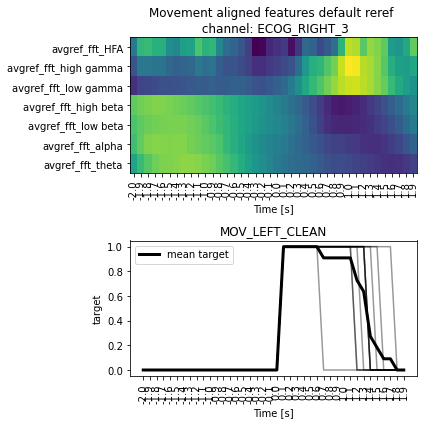

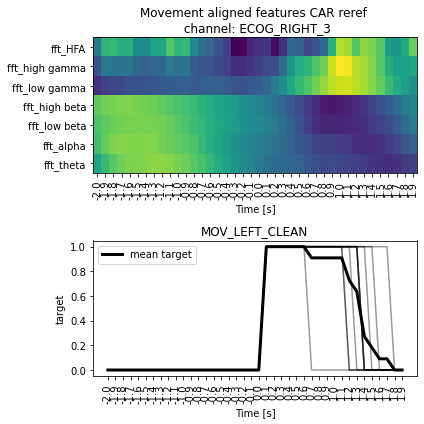

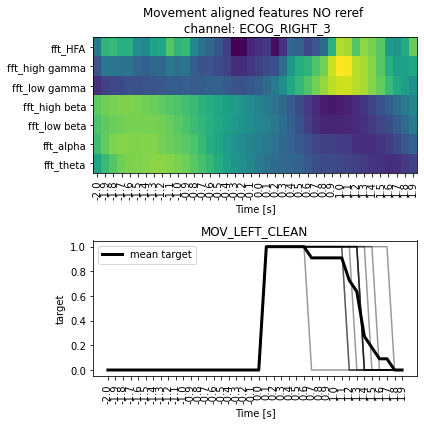

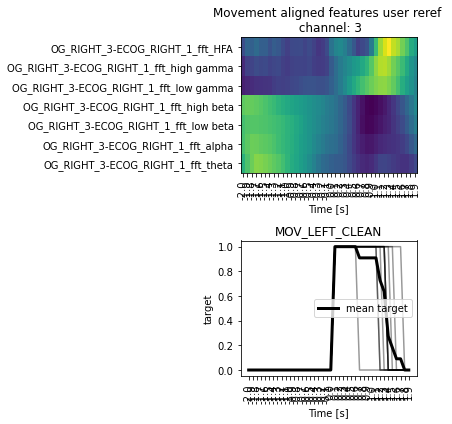

In [17]:
# init analyzer for default reref
feature_reader_default = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME
)

# plot for a single channel
ch_used = "ECOG_RIGHT_3"

feature_used_default = "fft"

feature_reader_default.plot_target_averaged_channel(
    ch=ch_used,
    list_feature_keywords=[feature_used_default],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
    show_plot=True,
    title="Movement aligned features default reref \n"
)
#---------------------------------------
# init analyzer for CAR reref
feature_reader_avg = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_avg, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_avg = "ECOG_RIGHT_3"

feature_used_avg = "fft"

feature_reader_avg.plot_target_averaged_channel(
    ch=ch_used_avg,
    list_feature_keywords=[feature_used_avg],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
    show_plot=True,
    title="Movement aligned features CAR reref \n"
)
#--------------------------------------------------
# init analyzer NO reref
feature_reader_None = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_None, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_None = "ECOG_RIGHT_3"

feature_used_None = "fft"

feature_reader_None.plot_target_averaged_channel(
    ch=ch_used_None,
    list_feature_keywords=[feature_used_None],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
    show_plot=True,
    title="Movement aligned features NO reref \n"
)

#-----------------------------------------------
# init analyzer user reref
feature_reader_userRef = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_userRef, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_userRef = "3"

feature_used_userRef = "fft"

feature_reader_userRef.plot_target_averaged_channel(
    ch=ch_used_userRef,
    list_feature_keywords=[feature_used_userRef],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
    show_plot=True,
    title="Movement aligned features user reref \n"
)

Take out mean target, put only one


![alt](path to png) | ![alt]() | ![alt]() | ![alt]()

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/rereferencing_example_LFP_default.png


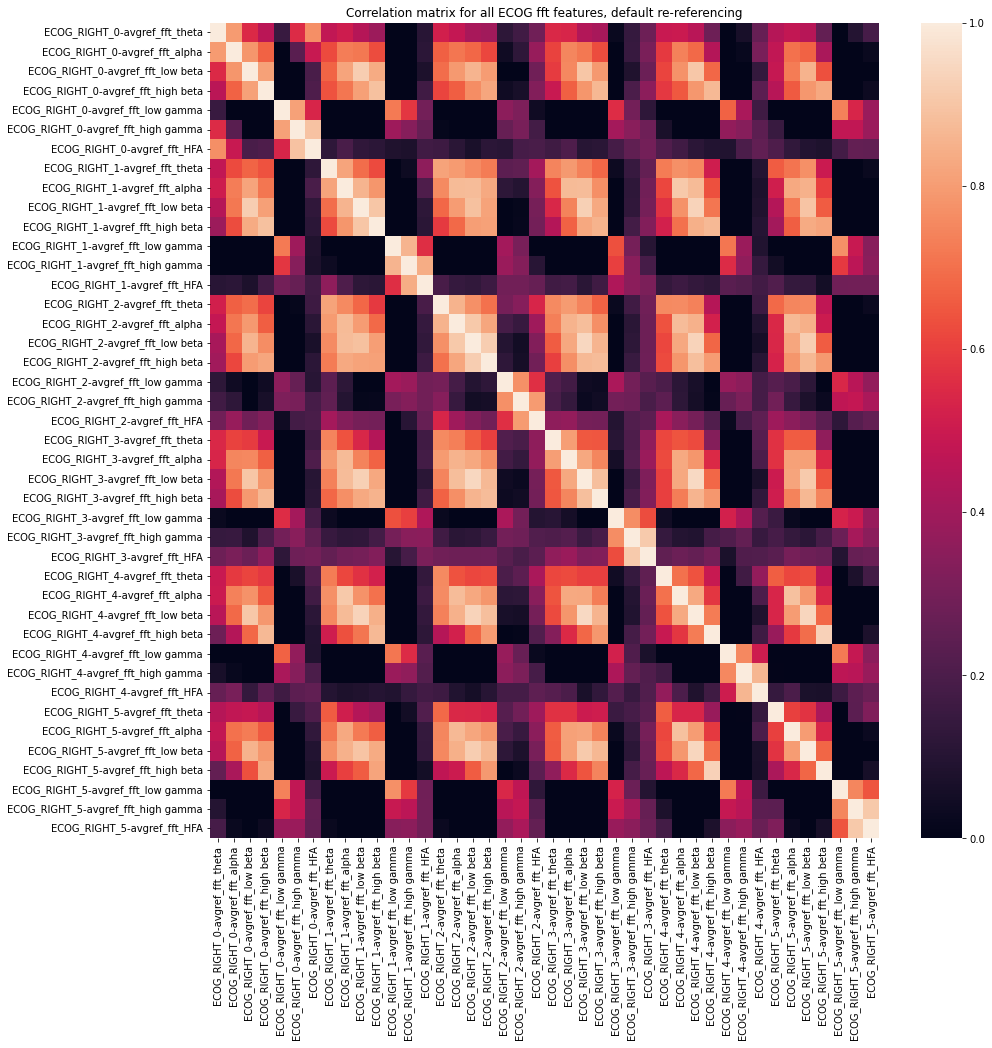

In [19]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_default.feature_arr.filter(regex='ECOG'),
        OUT_PATH= PATH_OUT,
        feature_names=feature_reader_default.feature_arr.filter(regex='ECOG').columns,
        feature_file=feature_reader_default.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all ECOG fft features, default re-referencing",
        save_plot_name="rereferencing_example_LFP_default.png"
)

correlation plots for high beta, make same colobar lims


Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/rereferencing_example_LFP_avgref.png


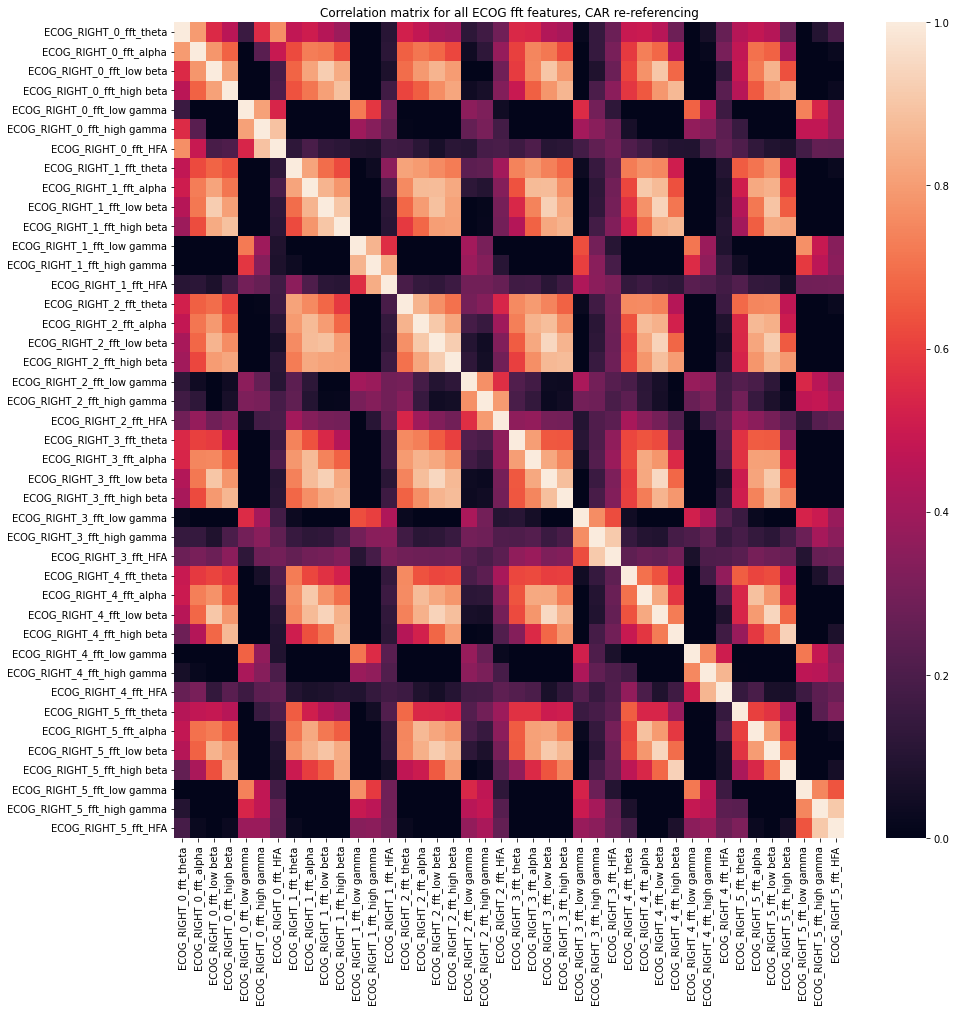

In [20]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_avg.feature_arr.filter(regex='ECOG'),
        OUT_PATH= PATH_OUT_avg,
        feature_names=feature_reader_avg.feature_arr.filter(regex='ECOG').columns,
        feature_file=feature_reader_avg.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all ECOG fft features, CAR re-referencing",
        save_plot_name="rereferencing_example_LFP_avgref.png"
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/none/rereferencing_example_LFP_None.png


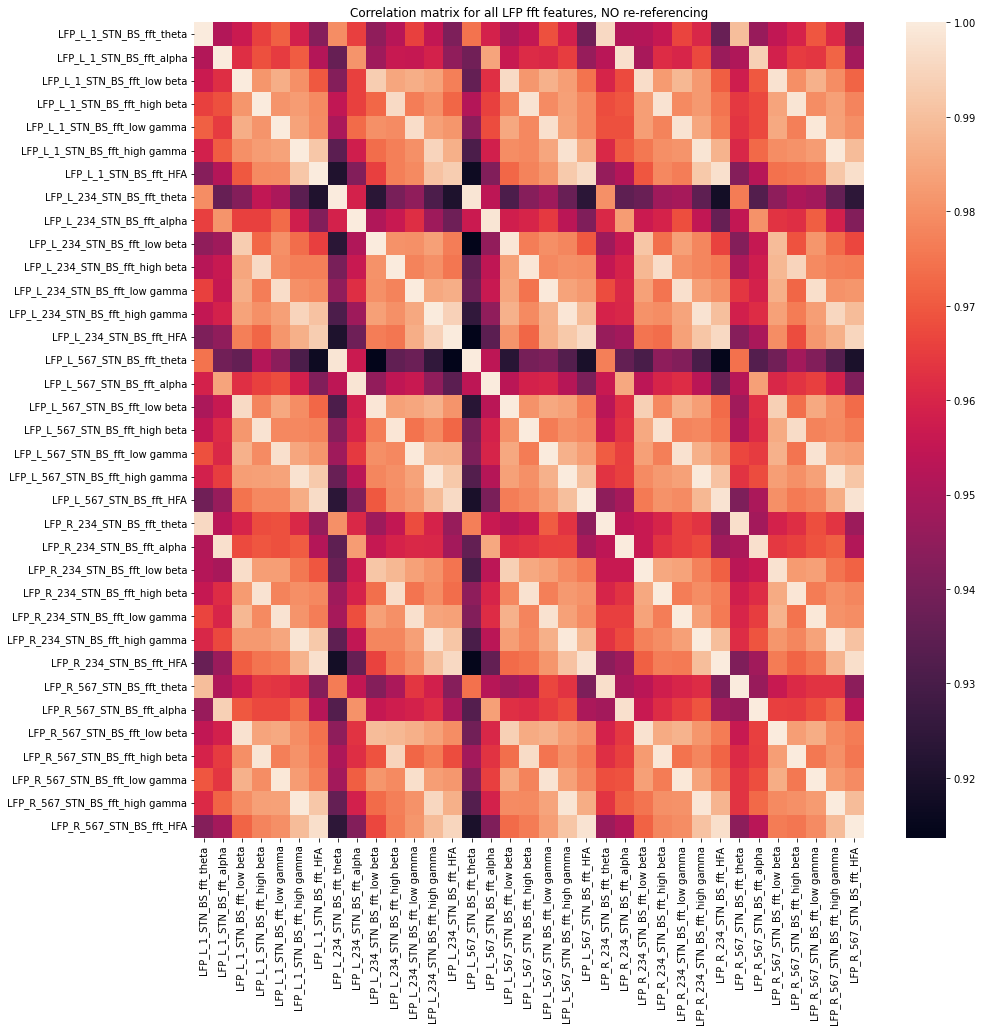

In [13]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_None.feature_arr.filter(regex='LFP'),
        OUT_PATH= PATH_OUT_None,
        feature_names=feature_reader_None.feature_arr.filter(regex='LFP').columns,
        feature_file=feature_reader_None.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all LFP fft features, NO re-referencing",
        save_plot_name="rereferencing_example_LFP_None.png"
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/userRef/rereferencing_example_LFP_userRef.png


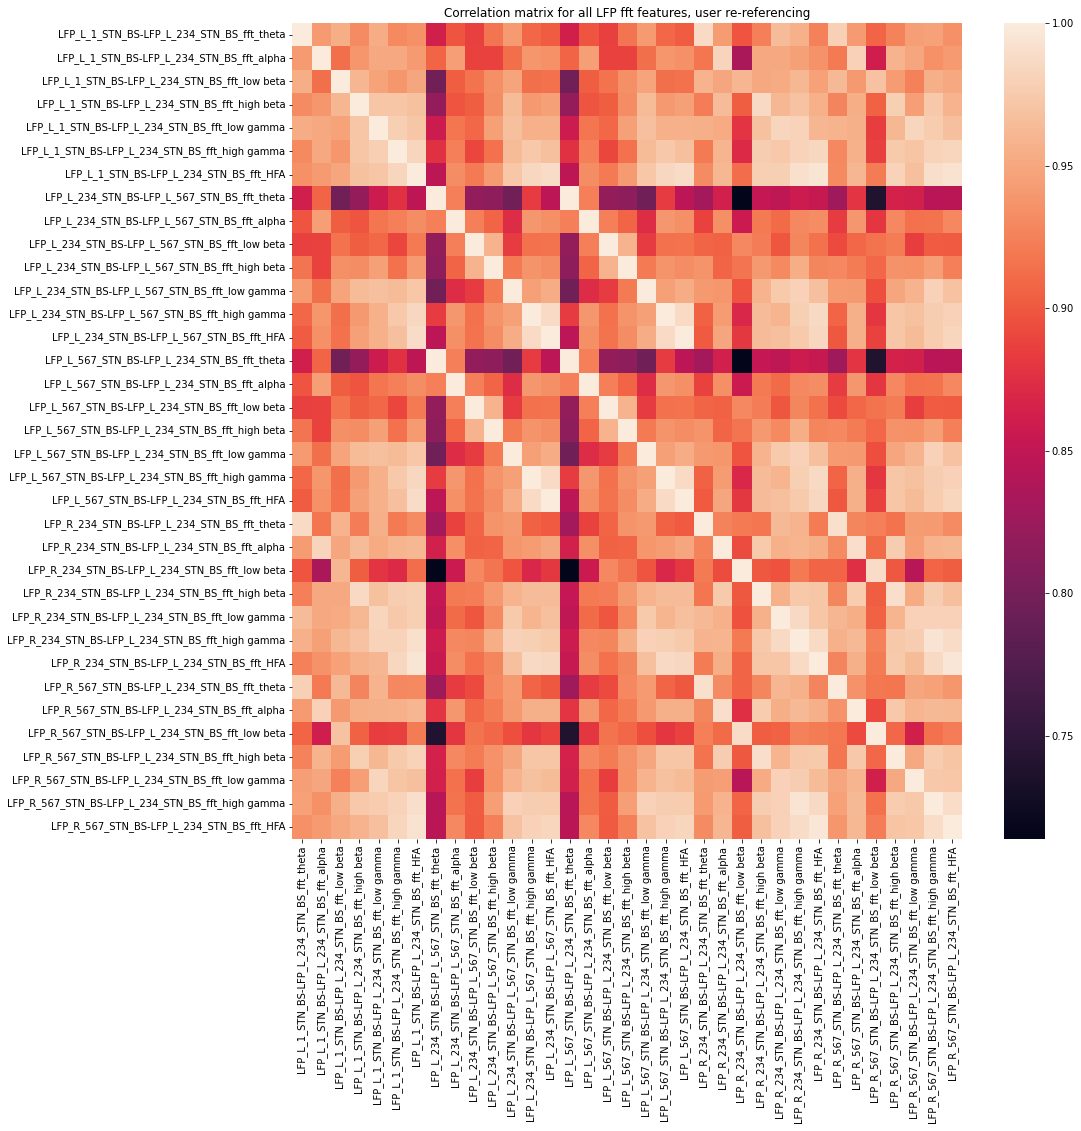

In [14]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_userRef.feature_arr.filter(regex='LFP'),
        OUT_PATH= PATH_OUT_userRef,
        feature_names=feature_reader_userRef.feature_arr.filter(regex='LFP').columns,
        feature_file=feature_reader_userRef.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all LFP fft features, user re-referencing",
        save_plot_name="rereferencing_example_LFP_userRef.png"
)

### Compare decoding performances
We will run the decoding pipeline for both CAR and bipolar re-referenced cases and compare the performances.
Since the default settings for LFP data correspond to bipolar re-referencing, we will use the variables `_default` and compare them to `_avg`.


model being saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/default/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_LM_ML_RES.p


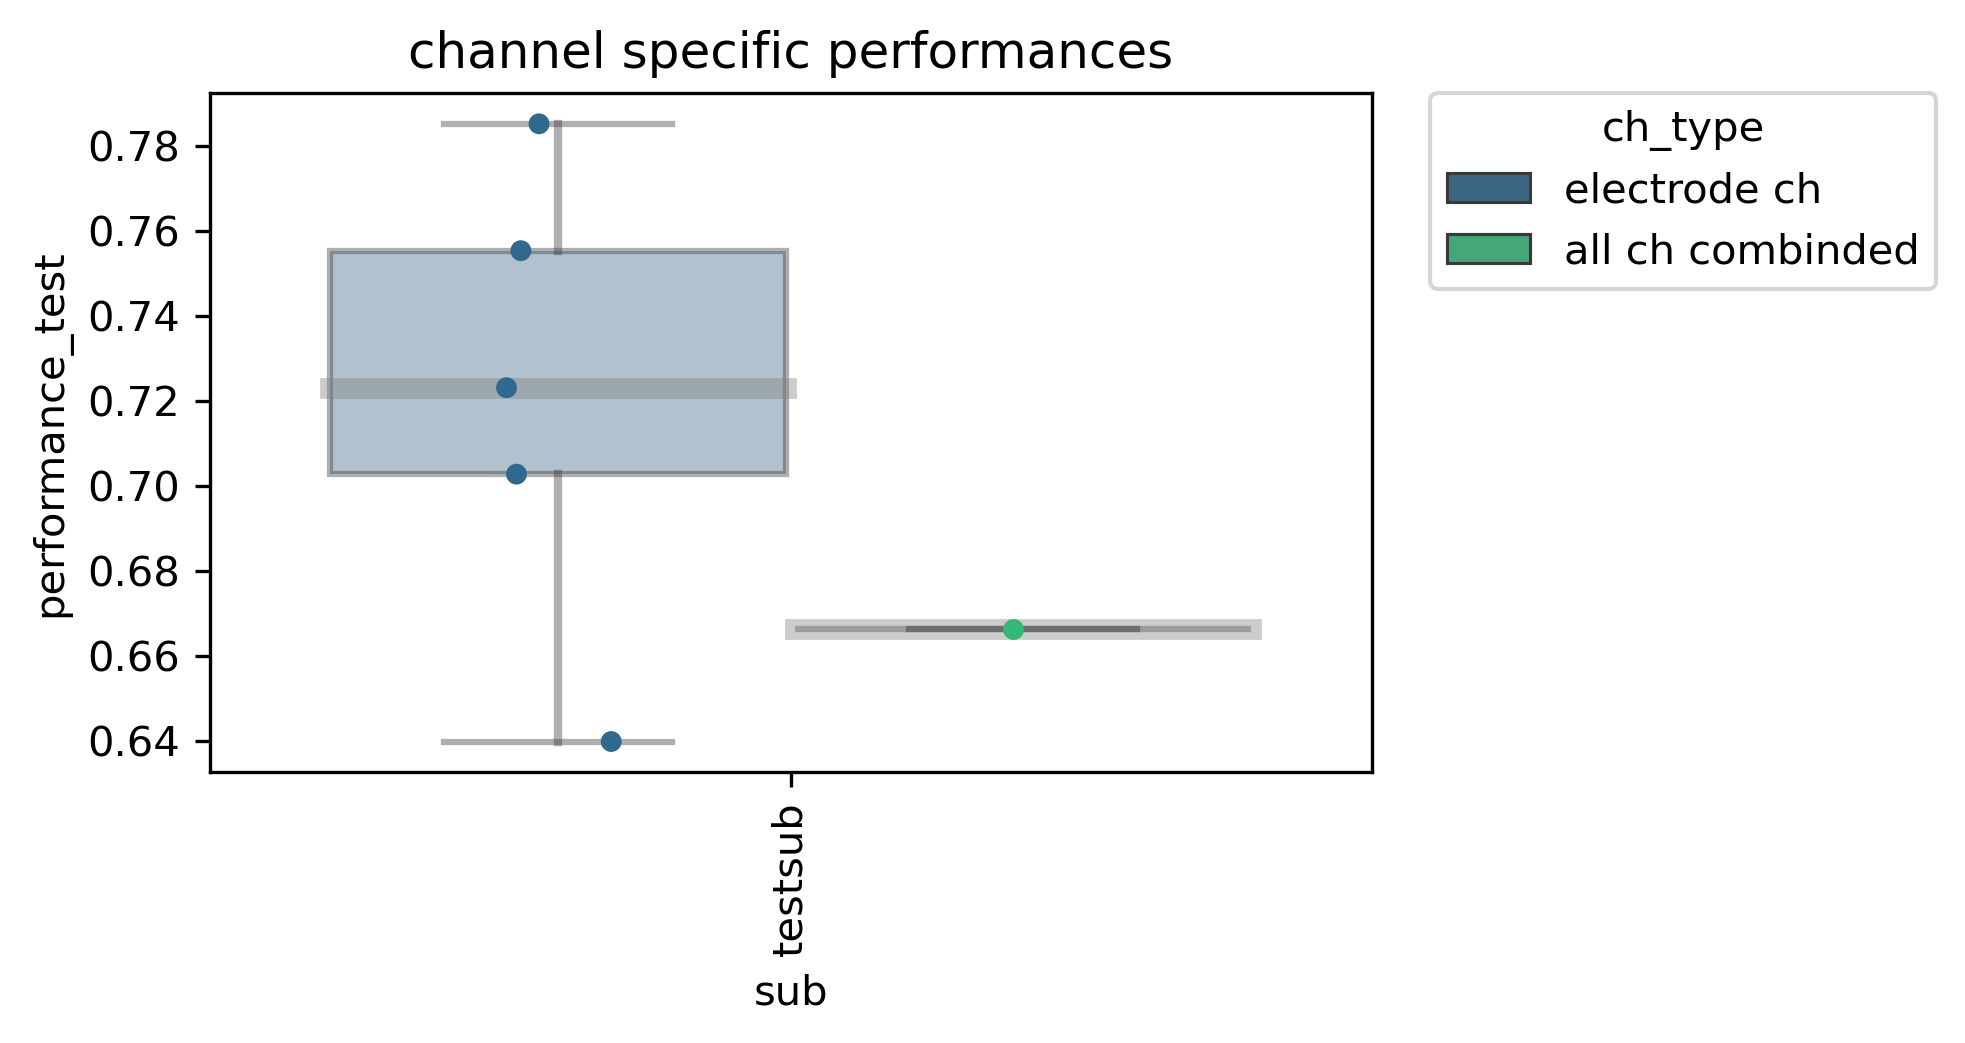

In [15]:
model = xgboost.XGBClassifier(use_label_encoder=False)


feature_reader_default.decoder = nm_decode.Decoder(
    features=feature_reader_default.feature_arr,
    label=feature_reader_default.label,
    label_name=feature_reader_default.label_name,
    used_chs=feature_reader_default.used_chs,
    model=model,
    eval_method=metrics.balanced_accuracy_score,
    cv_method=model_selection.KFold(n_splits=3, shuffle=True),
    get_movement_detection_rate=True,
    min_consequent_count=2,
    TRAIN_VAL_SPLIT=False,
    RUN_BAY_OPT=False,
    use_nested_cv=False,
    sfreq=feature_reader_default.settings["sampling_rate_features_hz"],
)

performances_default = feature_reader_default.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

df_per_default = feature_reader_default.get_dataframe_performances(performances_default)

nm_plots.plot_df_subjects(
    df_per_default, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT, RUN_NAME, RUN_NAME + "_decoding_performance_default.png")
)

model being saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/rereferencing/avg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_LM_ML_RES.p


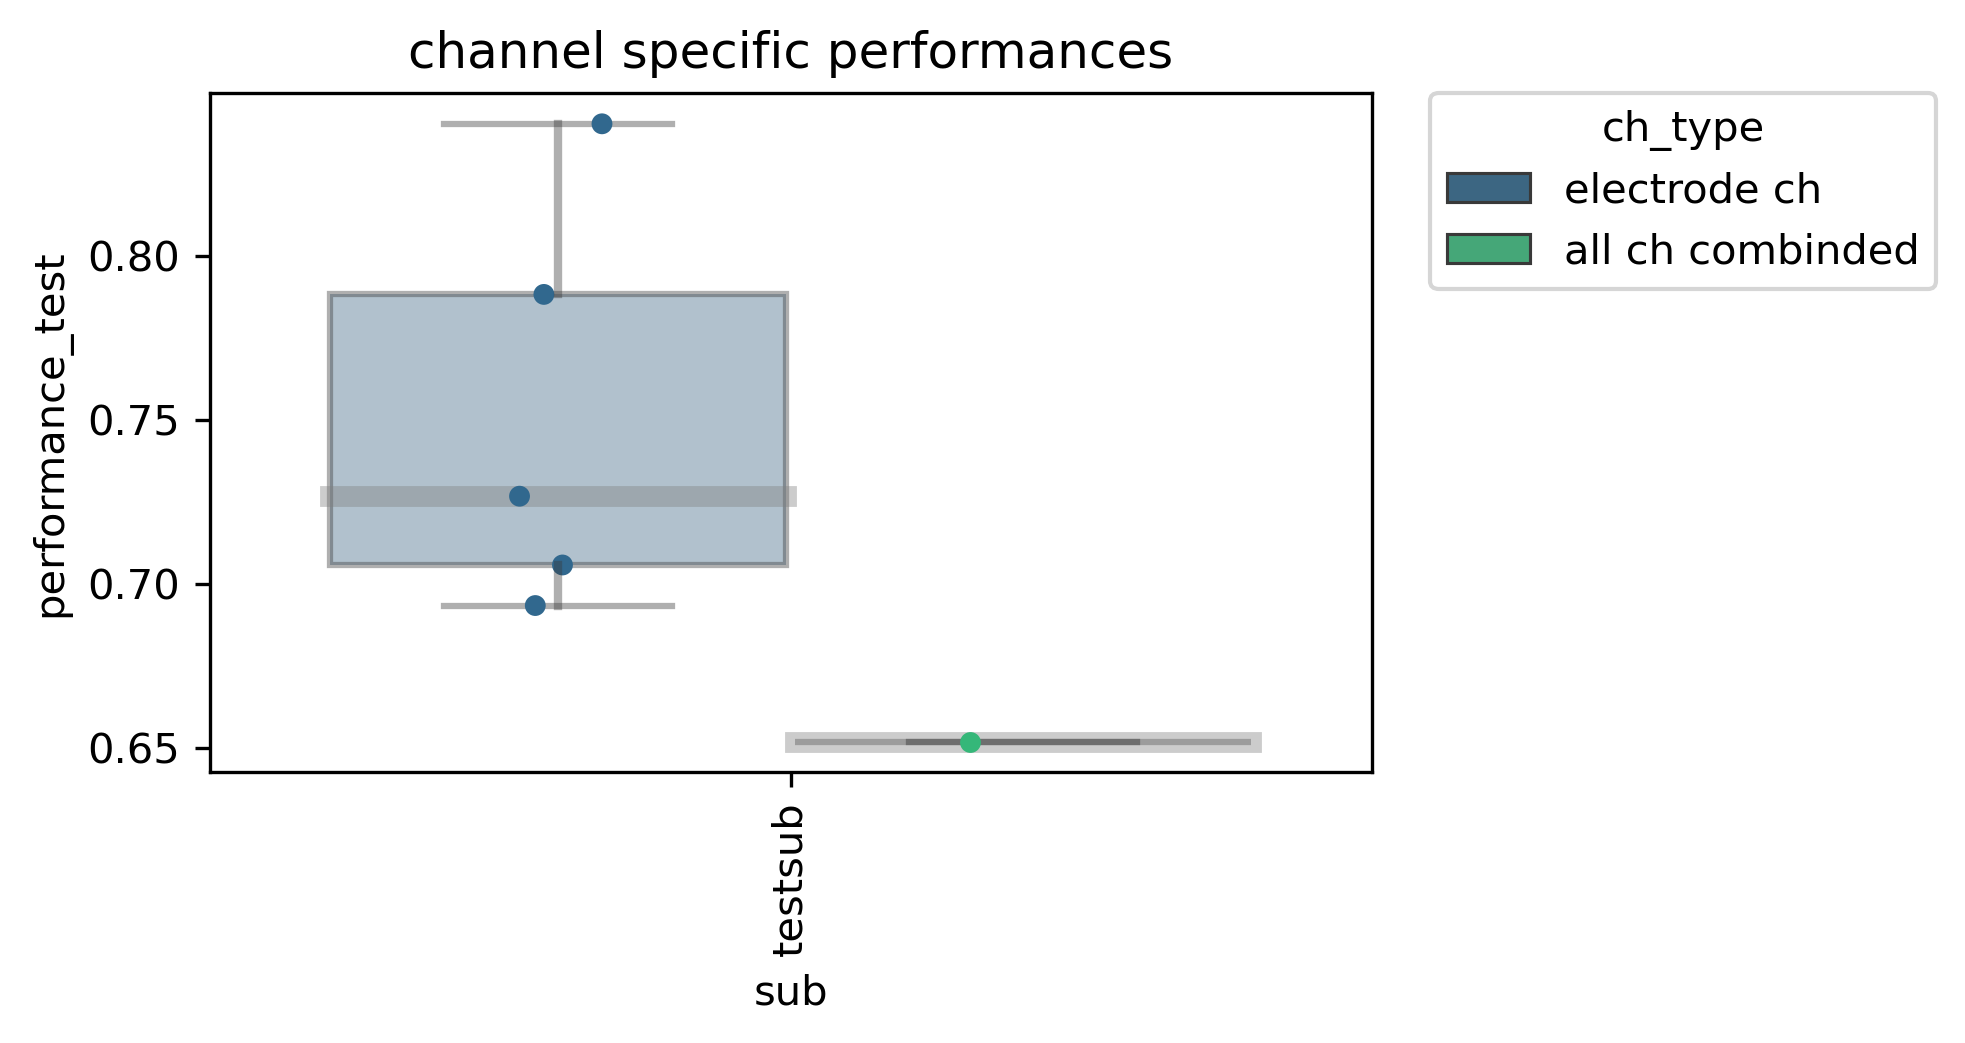

In [16]:
model = xgboost.XGBClassifier(use_label_encoder=False)


feature_reader_avg.decoder = nm_decode.Decoder(
    features=feature_reader_avg.feature_arr,
    label=feature_reader_avg.label,
    label_name=feature_reader_avg.label_name,
    used_chs=feature_reader_avg.used_chs,
    model=model,
    eval_method=metrics.balanced_accuracy_score,
    cv_method=model_selection.KFold(n_splits=3, shuffle=True),
    get_movement_detection_rate=True,
    min_consequent_count=2,
    TRAIN_VAL_SPLIT=False,
    RUN_BAY_OPT=False,
    use_nested_cv=False,
    sfreq=feature_reader_avg.settings["sampling_rate_features_hz"],
)

performances_avg = feature_reader_avg.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

df_per_avg = feature_reader_avg.get_dataframe_performances(performances_avg)

nm_plots.plot_df_subjects(
    df_per_avg, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT_avg, RUN_NAME, RUN_NAME + "_decoding_performance_avg.png")
)